In [23]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random

def generate_solar_data(days=365, panels_capacity_kw=10):
    # Create date range with hourly intervals
    start_date = datetime(2024, 1, 1)
    date_range = [start_date + timedelta(hours=i) for i in range(days*24)]
    
    # Initialize dataframe
    df = pd.DataFrame({
        'datetime': date_range,
        'day_of_year': [d.timetuple().tm_yday for d in date_range],
        'hour': [d.hour for d in date_range],
        'month': [d.month for d in date_range]
    })
    
    # Add season (1=Winter, 2=Spring, 3=Summer, 4=Fall)
    df['season'] = df['month'].apply(lambda m: (m%12+3)//3)
    
    # Generate weather data
    # Temperature (°C)
    df['temp_raw'] = df.apply(lambda row: 
                           15 + 10 * np.sin(2 * np.pi * (row['day_of_year']-172)/365) +  # Yearly cycle
                           5 * np.sin(2 * np.pi * row['hour']/24 - np.pi/2),             # Daily cycle
                           axis=1)
    
    # Add random variation to temperature
    df['temperature'] = df['temp_raw'] + np.random.normal(0, 2, len(df))
    
    # Cloud cover (0-1)
    df['cloud_cover_base'] = np.random.beta(2, 5, len(df))  # Beta distribution for cloud cover
    
    # Make cloud cover correlated with season (more clouds in winter)
    season_cloud_factor = {1: 1.4, 2: 1.0, 3: 0.7, 4: 1.1}
    df['cloud_cover'] = df.apply(
        lambda row: min(1, row['cloud_cover_base'] * season_cloud_factor[row['season']]),
        axis=1
    )
    
    # Precipitation probability based on cloud cover
    df['precipitation'] = df['cloud_cover'].apply(
        lambda c: max(0, np.random.normal(c*5 - 3, 1)) if c > 0.65 else 0
    )
    
    # Wind speed (m/s) - higher in winter
    df['wind_speed'] = df.apply(
        lambda row: abs(np.random.normal(
            4 + 2 * (row['season'] == 1 or row['season'] == 4), 2)),
        axis=1
    )
    
    # Calculate solar irradiance
    df['solar_irradiance_base'] = df.apply(
        lambda row: max(0, 1000 * np.sin(np.pi * row['hour']/12) 
                       if 6 <= row['hour'] <= 18 else 0),
        axis=1
    )
    
    # Adjust irradiance for day of year (season)
    day_length_factor = df['day_of_year'].apply(
        lambda d: 0.7 + 0.6 * np.sin(2 * np.pi * (d - 172) / 365)
    )
    df['solar_irradiance'] = df['solar_irradiance_base'] * day_length_factor * (1 - 0.75 * df['cloud_cover'])
    
    # Calculate solar generation (kW)
    # Base generation under ideal conditions
    df['ideal_generation'] = df['solar_irradiance'] * panels_capacity_kw / 1000
    
    # Temperature efficiency factor (decrease efficiency as temperature increases above 25°C)
    temp_efficiency = df['temperature'].apply(lambda t: 1 - max(0, (t - 25) * 0.004))
    
    # Final generation with weather effects and random variation
    df['generation_kw'] = df['ideal_generation'] * temp_efficiency * (1 - df['cloud_cover']*0.8)
    
    # Add random noise and system inefficiencies
    df['generation_kw'] = df['generation_kw'] * np.random.normal(0.98, 0.05, len(df))
    df['generation_kw'] = df['generation_kw'].apply(lambda x: max(0, x))  # Ensure non-negative
    
    # Drop intermediate calculation columns
    df = df.drop(['temp_raw', 'solar_irradiance_base', 'ideal_generation', 'cloud_cover_base'], axis=1)
    
    return df


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def build_generation_model(df):
    # Prepare the data
    features = ['temperature', 'cloud_cover', 'wind_speed', 'solar_irradiance', 
                'hour', 'day_of_year', 'month']
    target = 'generation_kw'
    
    # Extract features and target
    X = df[features].values
    y = df[target].values.reshape(-1, 1)
    
    # Scale the data
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X_scaled = X_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)
    
    # Define the model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        verbose=1
    )
    
    # Save the model
    model.save('generation_model.h5')
    
    # Save the scalers for later use
    import pickle
    with open('generation_X_scaler.pkl', 'wb') as f:
        pickle.dump(X_scaler, f)
    with open('generation_y_scaler.pkl', 'wb') as f:
        pickle.dump(y_scaler, f)
    
    return model, history, X_scaler, y_scaler, X_train, X_test, y_train, y_test


In [25]:
df = generate_solar_data(days=365, panels_capacity_kw=10)
df.to_csv("bhenchod.csv", sep='\t', encoding='utf-8', index=False, header=True)

# find no of records in df
print(len(df))

8760


In [26]:
# Train model
model, history, X_scaler, y_scaler, X_train, X_test, y_train, y_test = build_generation_model(df)
print("Model trained and saved as 'generation_model.h5'")

Epoch 1/50


c:\Users\barga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1975 - mae: 0.7592 - val_loss: 0.0774 - val_mae: 0.2547
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 0.1432 - mae: 0.2863 - val_loss: 0.0546 - val_mae: 0.1992
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0758 - mae: 0.2105 - val_loss: 0.0407 - val_mae: 0.1626
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.0515 - mae: 0.1684 - val_loss: 0.0222 - val_mae: 0.1244
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 0.0320 - mae: 0.1348 - val_loss: 0.0169 - val_mae: 0.1062
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.0252 - mae: 0.1184 - val_loss: 0.0101 - val_mae: 0.0830
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.0186 - mae: 0.1027 - val_loss: 0.0064 - val_mae: 0.0640
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0150 - mae: 0.0890 - val_loss: 0.0067 - val_mae: 0.0625
Epoch 9/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step

Model trained and saved as 'generation_model.h5'


In [27]:
evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {evaluation[0]}, Test MAE: {evaluation[1]}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 4.9449e-04 - mae: 0.0099
Test Loss (MSE): 0.0003767572052311152, Test MAE: 0.008792474865913391


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


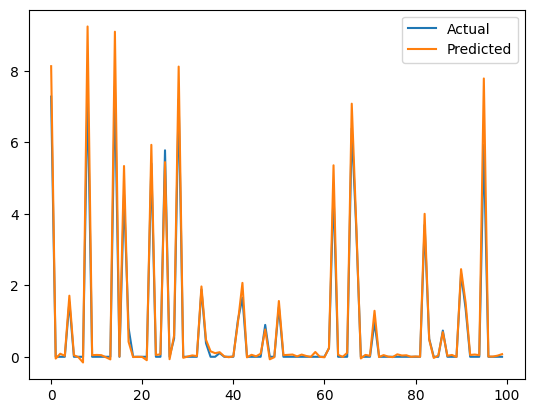

In [28]:
import matplotlib.pyplot as plt

y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

plt.plot(y_true[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.legend()
plt.show()

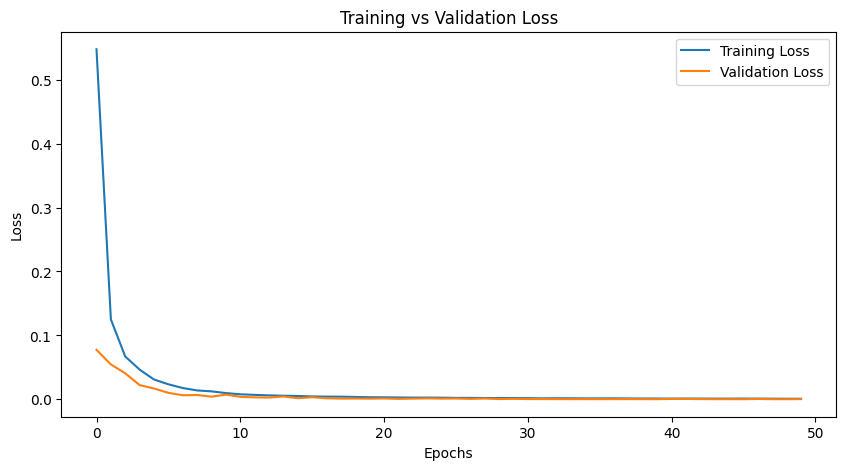

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
features = ['temperature', 'cloud_cover', 'wind_speed', 'solar_irradiance', 
                'hour', 'day_of_year', 'month']
target = 'generation_kw'
X = df[features].values
y = df[target].values.reshape(-1, 1)
# Scale the data
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

kf = KFold(n_splits=5)
mse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X_scaled):
    X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
    y_train_cv, y_test_cv = y_scaled[train_index], y_scaled[test_index]

    model_cv = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_cv.shape[1],)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model_cv.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model_cv.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, verbose=0)

    y_pred_cv = model_cv.predict(X_test_cv)
    mse_scores.append(mean_squared_error(y_test_cv, y_pred_cv))
    mae_scores.append(mean_absolute_error(y_test_cv, y_pred_cv))

print(f"Cross-validation MSE: {np.mean(mse_scores)} ± {np.std(mse_scores)}")
print(f"Cross-validation MAE: {np.mean(mae_scores)} ± {np.std(mae_scores)}")


c:\Users\barga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\barga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\barga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


c:\Users\barga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\barga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Cross-validation MSE: 0.0001702313957666763 ± 5.896281852627163e-05
Cross-validation MAE: 0.006199339458355232 ± 0.0010616386195637301


In [ ]:
import pickle
from tensorflow.keras.models import load_model

# Generate solar data for 365 days
new_data = generate_solar_data(days=365, panels_capacity_kw=10)

# Save the data to a CSV file for testing
new_data.to_csv("solar_data_test.csv", sep='\t', encoding='utf-8', index=False, header=True)

# Display the first few rows
print(new_data.head())

# Load the saved scalers
with open('generation_X_scaler.pkl', 'rb') as f:
    X_scaler = pickle.load(f)
with open('generation_y_scaler.pkl', 'rb') as f:
    y_scaler = pickle.load(f)

# Prepare test data
features = ['temperature', 'cloud_cover', 'wind_speed', 'solar_irradiance', 
            'hour', 'day_of_year', 'month']
X_test_new = new_data[features].values
X_test_scaled = X_scaler.transform(X_test_new)

# Make predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Add predictions to the dataframe for comparison
new_data['predicted_generation_kw'] = y_pred

# Save predictions for analysis
new_data.to_csv("solar_data_predictions.csv", sep='\t', encoding='utf-8', index=False)


             datetime  day_of_year  hour  month  season  temperature  \
0 2024-01-01 00:00:00            1     0      1       1     5.967938   
1 2024-01-01 01:00:00            1     1      1       1     7.029535   
2 2024-01-01 02:00:00            1     2      1       1     8.400192   
3 2024-01-01 03:00:00            1     3      1       1    10.528448   
4 2024-01-01 04:00:00            1     4      1       1    11.485410   

   cloud_cover  precipitation  wind_speed  solar_irradiance  generation_kw  
0     0.051898       0.000000    6.061778               0.0            0.0  
1     0.289928       0.000000    4.074796               0.0            0.0  
2     0.792408       0.403801    8.110781               0.0            0.0  
3     0.306391       0.000000    5.543092               0.0            0.0  
4     0.120626       0.000000    5.226155               0.0            0.0  


TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}